In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from DGPs import make_DGP_MF, \
                 make_DGP_jointly_Gaussian, \
                 make_DGP_inducing_locations_points, \
                 run_optimisation, \
                 sample, \
                 dtype

np.random.seed(1)

/home/ik359/Environments/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Generate data

In [2]:
D = 50
M = 10
S = 10
noise_std = 1e-2

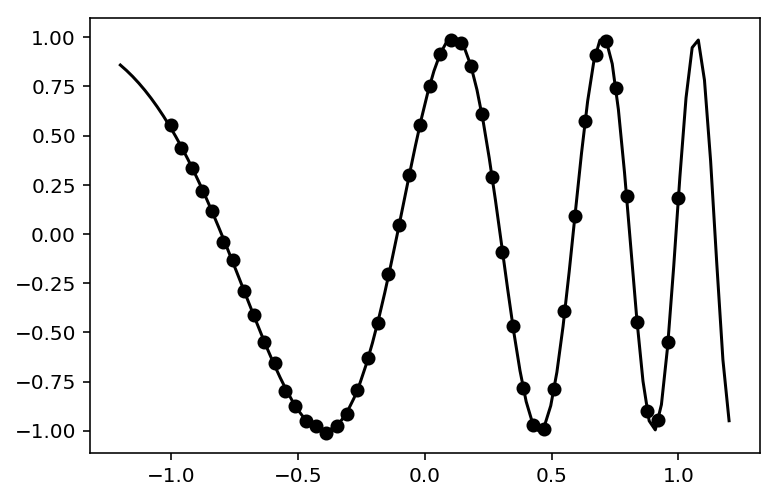

In [3]:
xs = np.linspace(-1, 1, D)
xs_test = np.linspace(-1.2, 1.2, 100)
                     
func = lambda x: np.sin(7 * np.exp(x))
ys = func(xs) + noise_std * np.random.randn(D) 

plt.plot(xs_test, func(xs_test), 'k')
plt.plot(xs, ys, 'ko')

In [4]:
def plot_DGP(xs_test, samples, fontsize=16, figsize=(20, 5)):
    titles = \
    [r'$f_1(\mathbf{X})$',
     r'$f_2(\mathbf{X})$',
     r'$(f_2 \circ f_1)(\mathbf{X})$']
    
    plt.figure(figsize=figsize)

    for p in range(3):
        plt.subplot(1, 3, p + 1)
        for s in samples[p]:
            plt.plot(xs_test, s, color='k', alpha=0.05)
            
        if p == 4:
            plt.plot(xs, ys, 'k.', markersize=12)
            
        plt.xticks([-1.5, -1, 0, 1, 1.5], ['', '-1', '0', '1', ''], fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        
        sns.despine(trim=True)
        plt.title(titles[p], fontsize=fontsize + 5)

# Mean-field

In [5]:
layers_MF, t_neg_lower_bound, t_X, t_Y = make_DGP_MF(n_layers=2, S=S, M=M, noise_std=noise_std, last_periodic=True)
feed_dict = {t_X: xs.reshape(-1, 1), t_Y: ys.reshape(-1, 1)}
t_lr = tf.placeholder(shape=(), dtype=dtype)
optimiser = tf.train.AdamOptimizer(learning_rate=t_lr).minimize(t_neg_lower_bound)
# gradients, variables = zip(*optimiser.compute_gradients(t_neg_lower_bound))
# gradients, _ = tf.clip_by_global_norm(gradients, 0.1)
# optimiser = optimiser.apply_gradients(zip(gradients, variables))
sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses = run_optimisation(t_neg_lower_bound, sess, optimiser, t_lr, feed_dict, n_steps=10000, lr_init=1e-3, lr_reduce=2, print_loss=1000)

0: 112148.16
1000: 332.42
2000: 287.86
3000: 314.81
4000: 448.71
5000: 254.10
6000: 155.77
7000: 137.47
8000: 132.95
9000: 167.96
10000: 91.48
0: 108.07
1000: 125.46
2000: 44.52
3000: 83.38
4000: 75.91
5000: 53.51
6000: 63.30
7000: 48.38
8000: 40.77
9000: 16.77
10000: 18.53
0: 24.76
1000: 21.13
2000: 0.45
3000: -8.88
4000: -8.81
5000: 13.62
6000: -19.52
7000: 26.08
8000: -12.75
9000: -3.09
10000: -7.58


In [6]:
feed_dict = {t_X: xs_test.reshape(-1, 1)}
samples_MF = sample(layers_MF, sess, feed_dict, S)

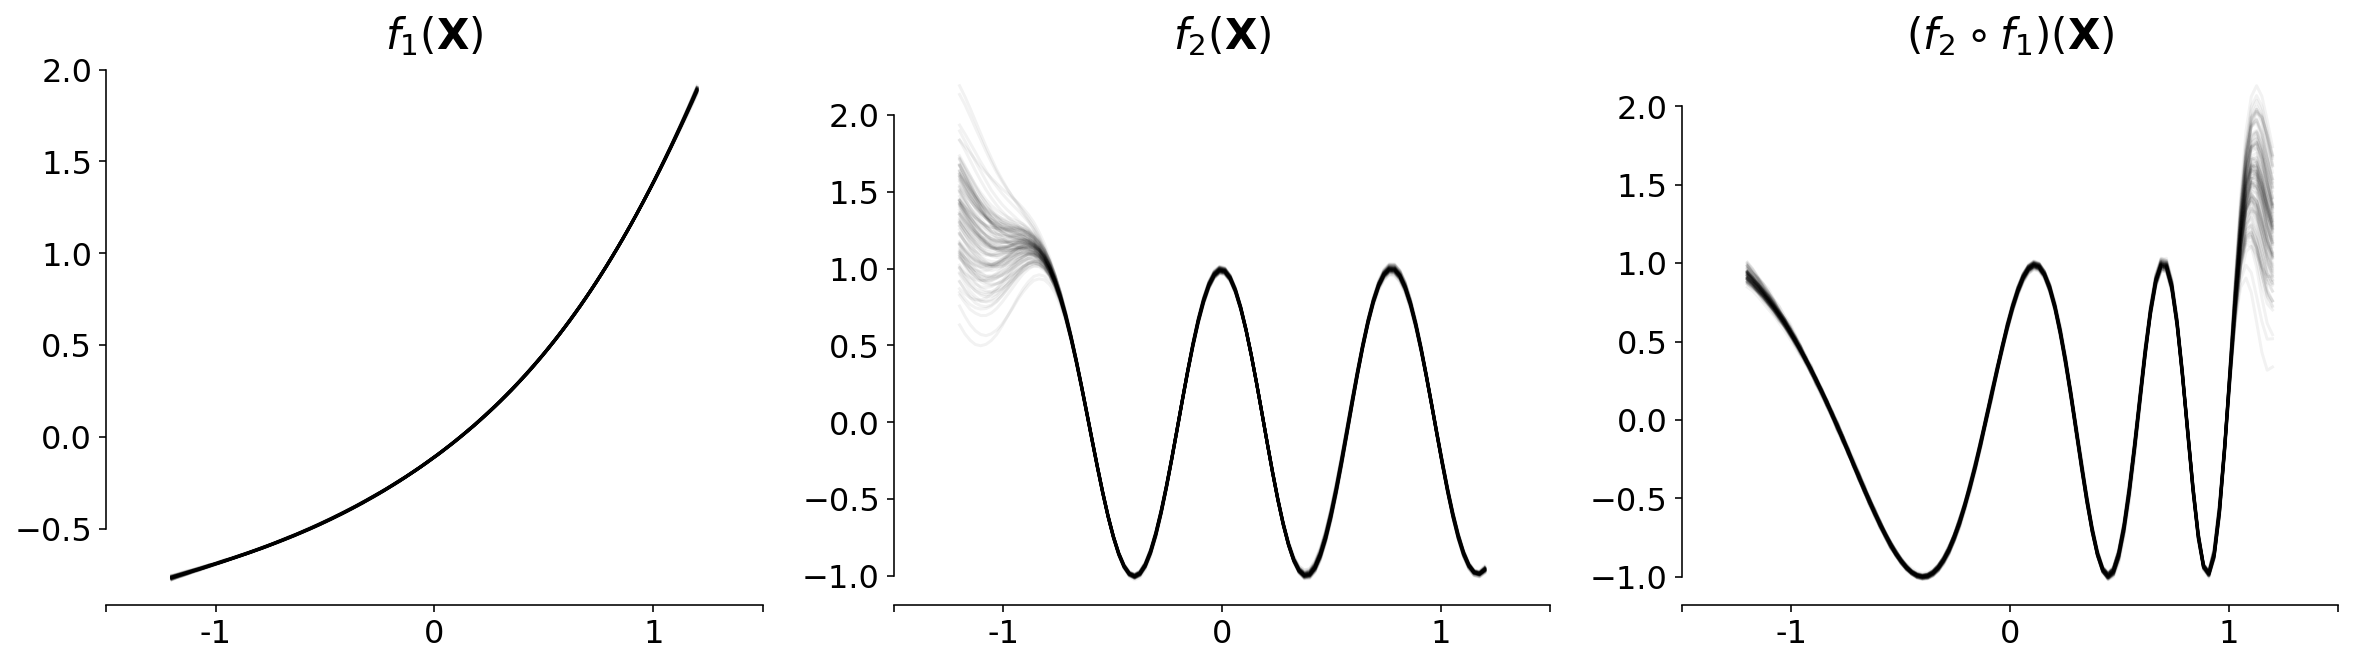

In [7]:
plot_DGP(xs_test, samples_MF)

# Jointly Gaussian

In [8]:
layers_jointly_Gaussian, t_neg_lower_bound, t_X, t_Y = \
    make_DGP_jointly_Gaussian(n_layers=2, S=S, M=M, noise_std=noise_std, last_periodic=True)
feed_dict = {t_X: xs.reshape(-1, 1), t_Y: ys.reshape(-1, 1)}
t_lr = tf.placeholder(shape=(), dtype=dtype)
optimiser = tf.train.AdamOptimizer(learning_rate=t_lr).minimize(t_neg_lower_bound)
# gradients, variables = zip(*optimiser.compute_gradients(t_neg_lower_bound))
# gradients, _ = tf.clip_by_global_norm(gradients, 0.1)
# optimiser = optimiser.apply_gradients(zip(gradients, variables))
sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses = run_optimisation(t_neg_lower_bound, sess, optimiser, t_lr, feed_dict, n_steps=10000, lr_init=1e-3, lr_reduce=2, print_loss=1000)

0: 111684.74
1000: 466.87
2000: 297.64
3000: 360.26
4000: 202.13
5000: 281.29
6000: 179.72
7000: 119.14
8000: 211.93
9000: 85.80
10000: 54.66
0: 140.47
1000: 30.99
2000: 90.57
3000: 32.25
4000: 43.61
5000: 43.74
6000: 28.96
7000: 26.73
8000: 20.66
9000: 34.76
10000: 20.78
0: 24.66
1000: -5.83
2000: 4.94
3000: 21.08
4000: -4.98
5000: -4.74
6000: -1.80
7000: -13.83
8000: -21.96
9000: -9.38
10000: -12.29


In [9]:
feed_dict = {t_X: xs_test.reshape(-1, 1)}
samples_jointly_Gaussian = sample(layers_jointly_Gaussian, sess, feed_dict, S)

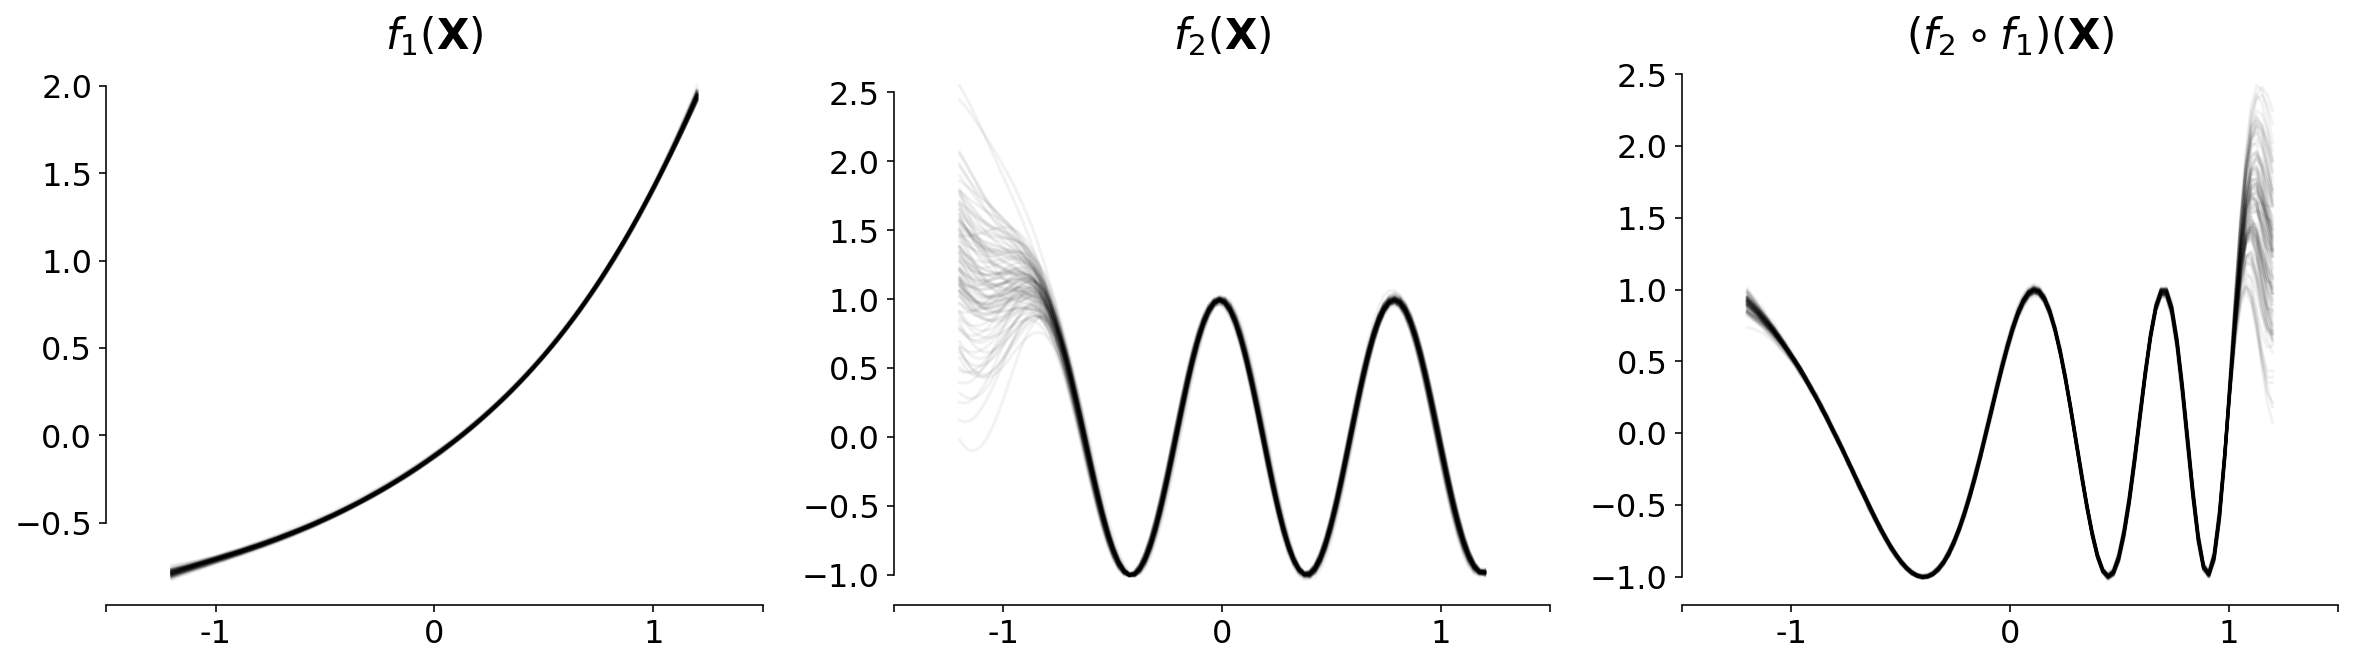

In [ ]:
plot_DGP(xs_test, samples_jointly_Gaussian)

# Inducing inputs as inducing locations

In [ ]:
layers_inducing_locations_points, t_neg_lower_bound, t_X, t_Y, t_beta_jitter = \
    make_DGP_inducing_locations_points(n_layers=2, S=S, M=M, noise_std=noise_std, last_periodic=True)
feed_dict = {t_X: xs.reshape(-1, 1), t_Y: ys.reshape(-1, 1), t_beta_jitter: 1e8}
t_lr = tf.placeholder(shape=(), dtype=dtype)
optimiser = tf.train.AdamOptimizer(learning_rate=t_lr).minimize(t_neg_lower_bound)
# gradients, variables = zip(*optimiser.compute_gradients(t_neg_lower_bound))
# gradients, _ = tf.clip_by_global_norm(gradients, 0.1)
# optimiser = optimiser.apply_gradients(zip(gradients, variables))
sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses = run_optimisation(t_neg_lower_bound, sess, optimiser, t_lr, feed_dict, n_steps=10000, lr_init=1e-3, lr_reduce=2, print_loss=1000)

0: 112372.32
1000: 5652.45
2000: 537.87
3000: 216.65
4000: 289.63
5000: 289.15
6000: 180.31
7000: 175.15
8000: 177.99
9000: 115.52
10000: 71.21
0: 96.87
1000: 85.47
2000: 100.47
3000: 56.48
4000: 84.97
5000: 30.20
6000: 23.61
7000: 52.37
8000: 0.20
9000: 20.15
10000: -12.38
0: -23.61
1000: -11.43
2000: -21.15
3000: -22.17
4000: 1.08
5000: -7.99
6000: -40.92
7000: -38.07
8000: -39.39
9000: -37.51


In [ ]:
feed_dict = {t_X: xs_test.reshape(-1, 1)}
samples_inducing_locations_points = sample(layers_inducing_locations_points, sess, feed_dict, S)

In [ ]:
plot_DGP(xs_test, samples_inducing_locations_points)